In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils_plot import plot_mean_std, plot_all_roc_curves, plot_all_pr_curves, plot_all_comparisons, print_latex_performance

python inference.py --dataset_location data/nacc_scaled_corrected.csv --dataset_id nacc

python inference.py --dataset_location data/nacc_scaled_corrected.csv --dataset_id nacc --do_single_pass

For balanced run:

python inference.py --dataset_location data/nacc_scaled_corrected.csv --dataset_id nacc --wb_model_id 18wkp0n2

... and change file location from `latest_output_nacc_50.csv` to `latest_output_nacc_50_18wkp0n2.csv`

In [2]:
nacc_diag = pd.read_csv('../data/nacc_diagnosis.csv', index_col=0)
nacc_diag.shape

(5209, 1)

In [ ]:
res_df = pd.read_csv('latest_output_nacc_50.csv', index_col=0)
res_df

In [ ]:
joined_df = res_df.join(nacc_diag, how='inner')
joined_df

In [ ]:
joined_df['diagnosis'] = joined_df['diagnosis'].map({'AD': 1, 'OD': 0, 'Control': 0, 'OND': 0})
joined_df

In [ ]:
single_pass = pd.read_csv('latest_output_nacc_1.csv', index_col=0)
single_pass = single_pass.join(nacc_diag, how='inner')
single_pass['diagnosis'] = single_pass['diagnosis'].map({'AD': 1, 'OD': 0, 'Control': 0, 'OND': 0})
single_pass

In [ ]:
# Creating column of extremes to better evaluate distance to extremes and order
joined_df['extremes'] = joined_df['mean']
joined_df.loc[joined_df['extremes'] >= 0.5, 'extremes'] = 1 - joined_df.loc[joined_df['extremes'] >= 0.5, 'extremes']
joined_df

In [ ]:
single_pass['extremes'] = single_pass['mean']
single_pass.loc[single_pass['extremes'] >= 0.5, 'extremes'] = 1 - single_pass.loc[single_pass['extremes'] >= 0.5, 'extremes']
single_pass

# Performance Metrics

In [9]:
print_latex_performance(single_pass)

0.72 & 0.76 & 0.68 & 0.73 & 0.56 & 0.83 \\ 
0.22
0.17


In [10]:
print_latex_performance(joined_df)

0.72 & 0.76 & 0.68 & 0.73 & 0.56 & 0.83 \\ 
0.21
0.17


In [9]:
# Output for run 18wkp0n2 (balanced training set)
print_latex_performance(joined_df)

0.71 & 0.76 & 0.7 & 0.72 & 0.55 & 0.83 \\ 
0.21
0.17


In [11]:
joined_df.loc[joined_df['mean'] < 0.5, 'mean'] = 0
joined_df.loc[joined_df['mean'] >= 0.5, 'mean'] = 1

In [12]:
joined_df.loc[(joined_df['mean'] == joined_df['diagnosis']) & (joined_df['mean'] == 1), 'group'] = 'TP'
joined_df.loc[(joined_df['mean'] == joined_df['diagnosis']) & (joined_df['mean'] == 0), 'group'] = 'TN'

joined_df.loc[(joined_df['mean'] != joined_df['diagnosis']) & (joined_df['mean'] == 1), 'group'] = 'FN'
joined_df.loc[(joined_df['mean'] != joined_df['diagnosis']) & (joined_df['mean'] == 0), 'group'] = 'FP'

joined_df.loc[joined_df['mean'] == joined_df['diagnosis'], 'group2'] = 'Correct Predictions'
joined_df.loc[joined_df['mean'] != joined_df['diagnosis'], 'group2'] = 'Incorrect Predictions'

In [13]:
import seaborn as sns

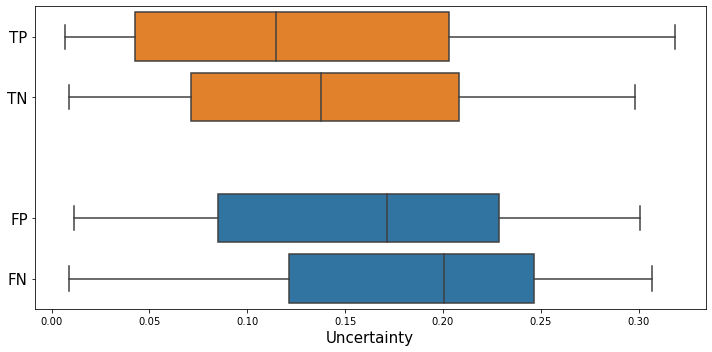

In [14]:
plt.subplots(figsize=(10, 5))

g1 = sns.boxplot(data=joined_df, y='group', x='std', order=['TP', 'TN', '', 'FP', 'FN'], palette = {'TP': 'tab:orange', 'TN': 'tab:orange', 'FP': 'tab:blue', 'FN': 'tab:blue', '':'b'})
g1.set(ylabel=None)
#g1.set(xlabel='Uncertainty')

g1.tick_params(axis='y', labelsize=15)
g1.set_xlabel('Uncertainty',fontsize=15)

g1.set_yticks([0, 1, 3, 4])

plt.tight_layout()
plt.savefig('figs/nacc_uncertainty.png')

In [24]:
joined_df['group'].value_counts()

TN    2574
TP    1168
FN     929
FP     538
Name: group, dtype: int64

In [15]:
from scipy import stats

In [16]:
print(stats.f_oneway(joined_df.loc[(joined_df['mean'] == joined_df['diagnosis']) & (joined_df['mean'] == 1), 'std'].values, 
               joined_df.loc[(joined_df['mean'] == joined_df['diagnosis']) & (joined_df['mean'] == 0), 'std'].values,
               joined_df.loc[(joined_df['mean'] != joined_df['diagnosis']) & (joined_df['mean'] == 1), 'std'].values,
               joined_df.loc[(joined_df['mean'] != joined_df['diagnosis']) & (joined_df['mean'] == 0), 'std'].values))

print(stats.kruskal(joined_df.loc[(joined_df['mean'] == joined_df['diagnosis']) & (joined_df['mean'] == 1), 'std'].values, 
               joined_df.loc[(joined_df['mean'] == joined_df['diagnosis']) & (joined_df['mean'] == 0), 'std'].values,
               joined_df.loc[(joined_df['mean'] != joined_df['diagnosis']) & (joined_df['mean'] == 1), 'std'].values,
               joined_df.loc[(joined_df['mean'] != joined_df['diagnosis']) & (joined_df['mean'] == 0), 'std'].values))

F_onewayResult(statistic=93.39700546208802, pvalue=7.149902615225744e-59)
KruskalResult(statistic=269.58650137566025, pvalue=3.7925058330507046e-58)


In [17]:
# two-sided Welch's t-test
stats.ttest_ind(joined_df.loc[joined_df['mean'] == joined_df['diagnosis'], 'std'].values, 
                joined_df.loc[joined_df['mean'] != joined_df['diagnosis'], 'std'].values,
               equal_var=False)

Ttest_indResult(statistic=-15.114395090604036, pvalue=1.2357404348991917e-49)

## MC-Drop vs single-pass: AUC-ROC Curve

Best treshold for MC-Drop: 0.5115083456039429
Best treshold for Single Pass: 0.5894964933395386


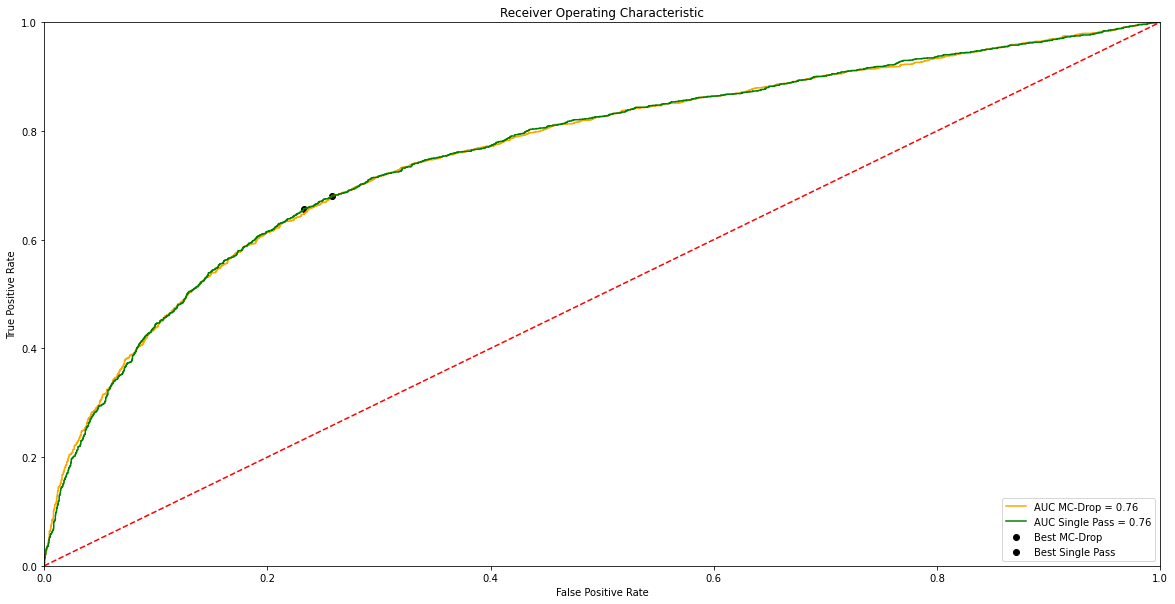

In [10]:
joined_dfplot_all_roc_curves(joined_df, single_pass)

# MC-Drop (uncertainty) vs MC-Drop (delta) vs single-pass (delta)

## At threshold = 0.5

#####################################################################################
################# MC-Drop with uncertainty thresholding
#####################################################################################


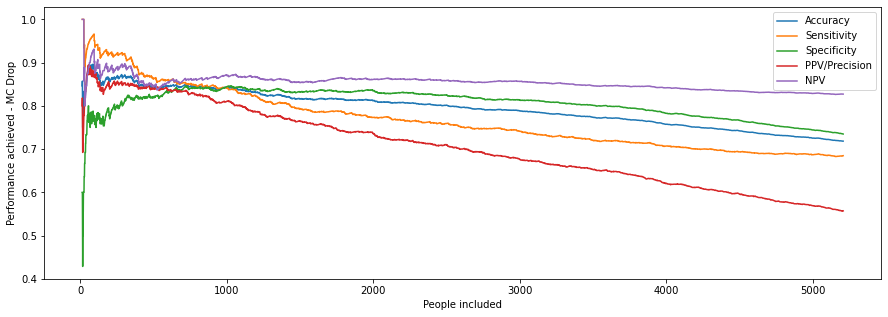

#####################################################################################
################# MC-Drop vs Single-pass
#####################################################################################


/local/sdc/tmla2/adni_phenotypes/results/utils_plot.py:103: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn / (tn + fn)


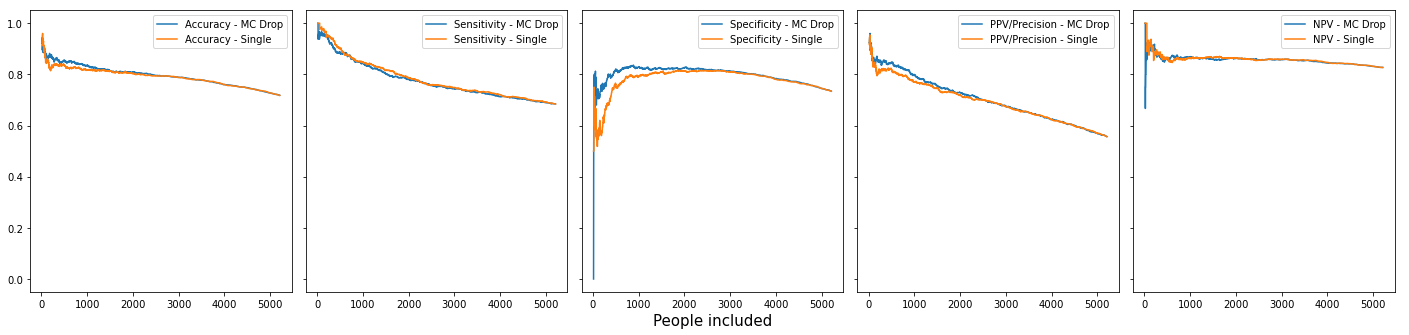

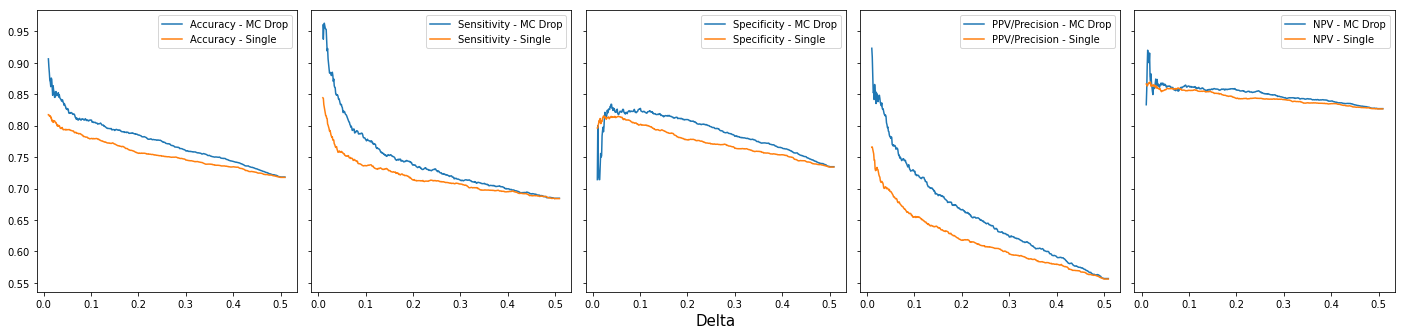

#####################################################################################
################# All 3 approaches together
#####################################################################################


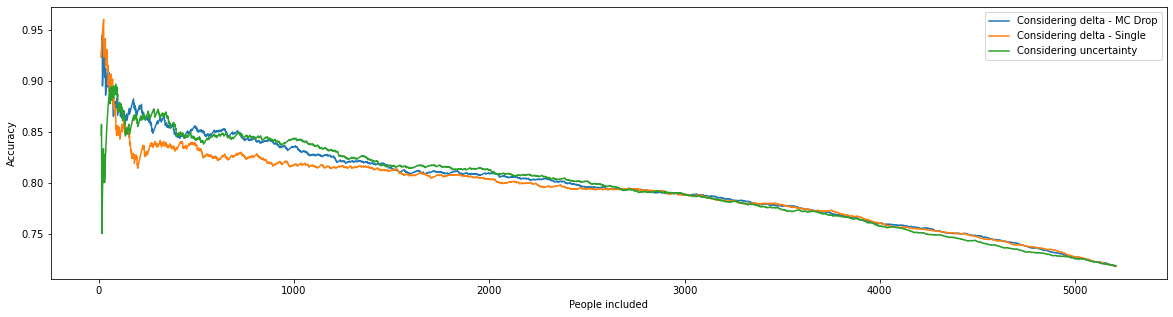

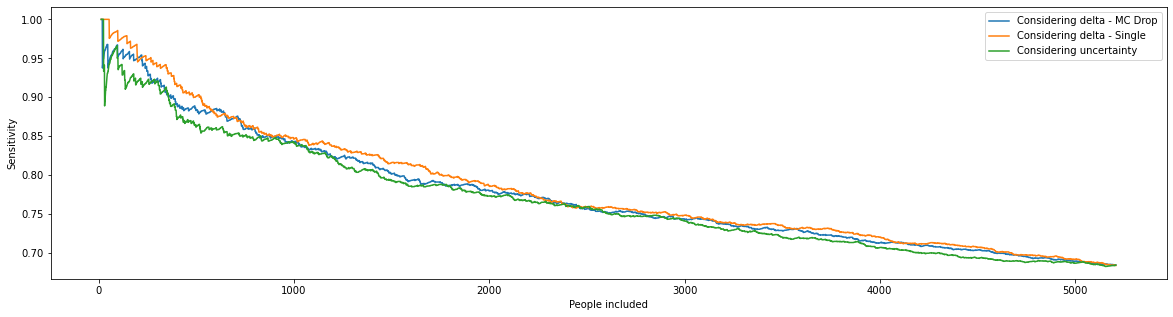

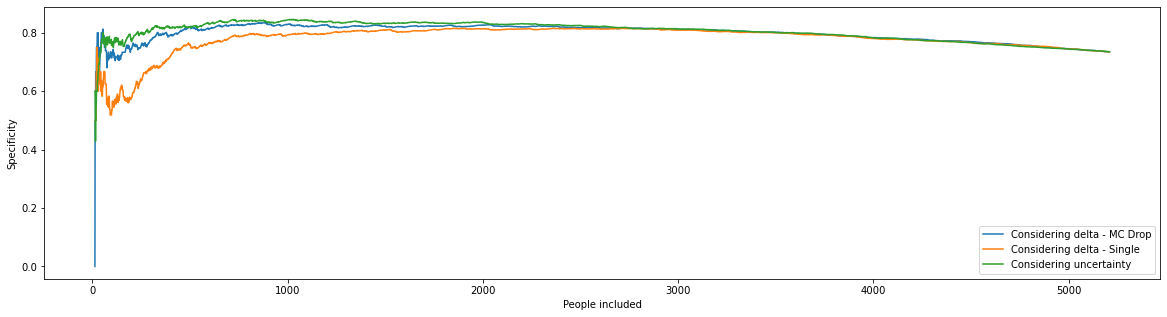

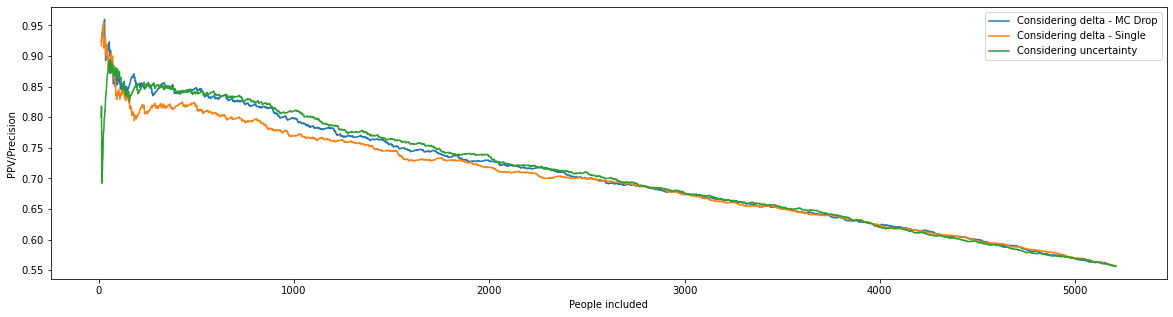

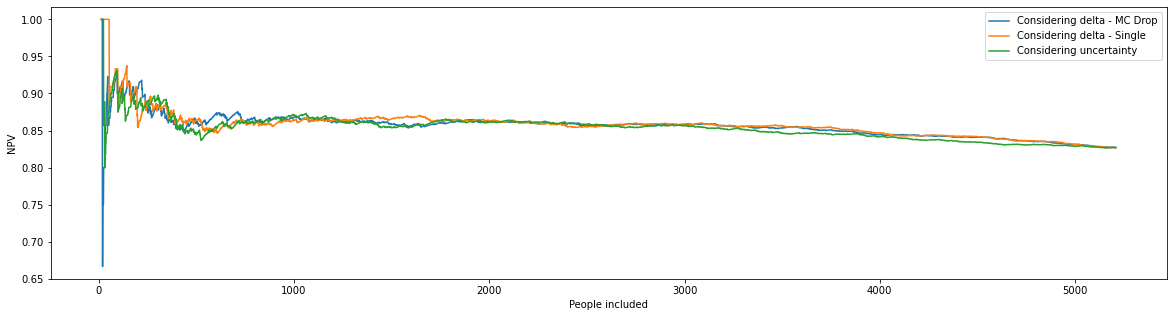

CPU times: user 2min 11s, sys: 184 ms, total: 2min 11s
Wall time: 2min 11s


In [11]:
%%time
plot_all_comparisons(joined_df, single_pass, threshold=0.5, starting_num_people=13, save_plot='figs/nacc_4_delta.pdf')

## At threshold = 0.582169

#####################################################################################
################# MC-Drop with uncertainty thresholding
#####################################################################################


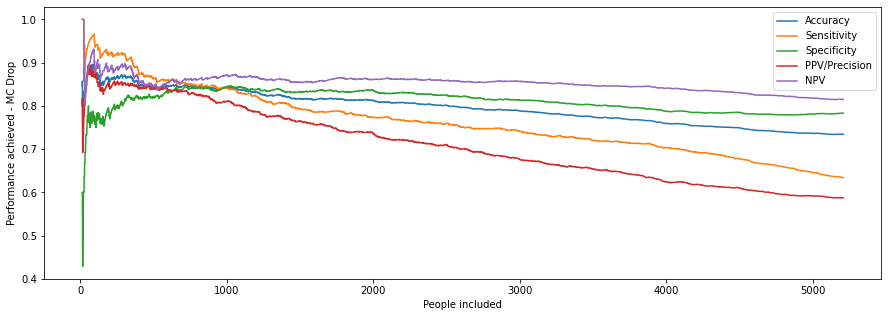

#####################################################################################
################# MC-Drop vs Single-pass
#####################################################################################


/local/sdc/tmla2/adni_phenotypes/results/utils_plot.py:99: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn / (tn + fn)


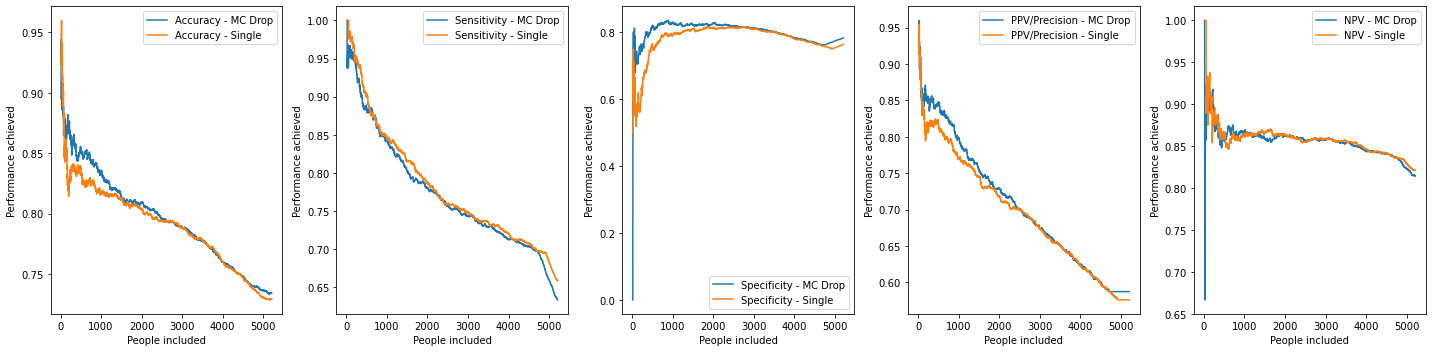

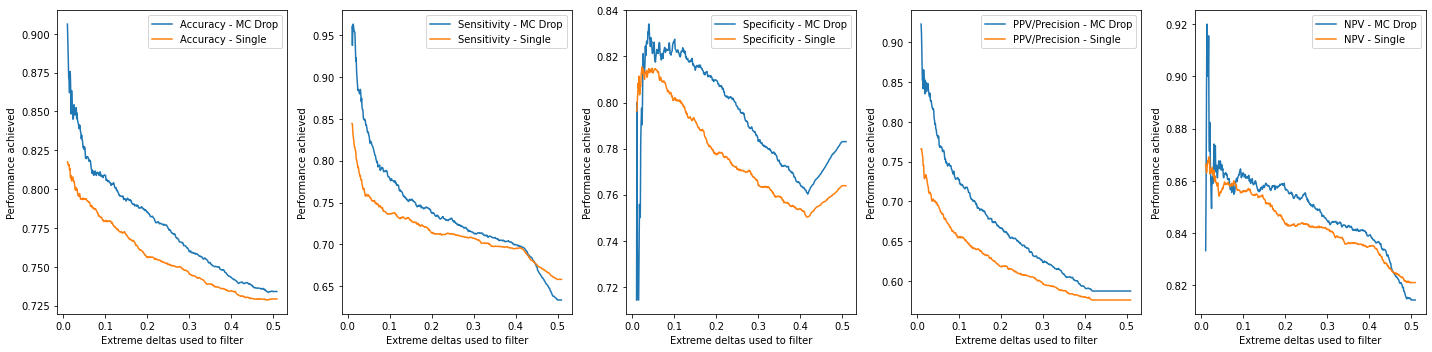

#####################################################################################
################# All 3 approaches together
#####################################################################################


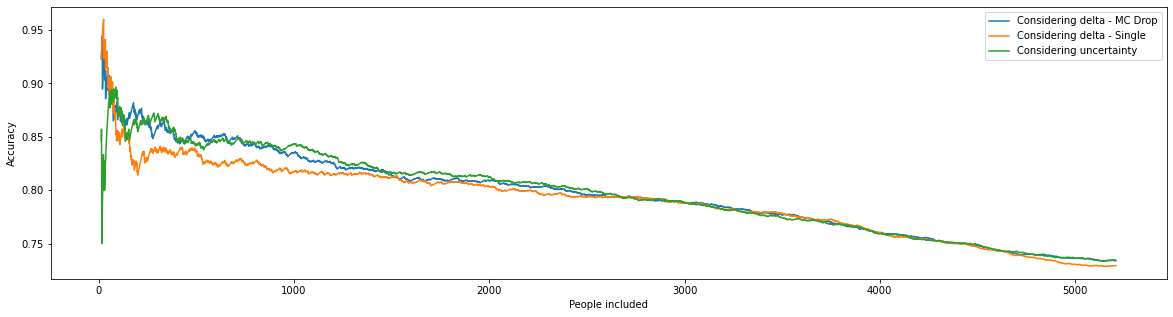

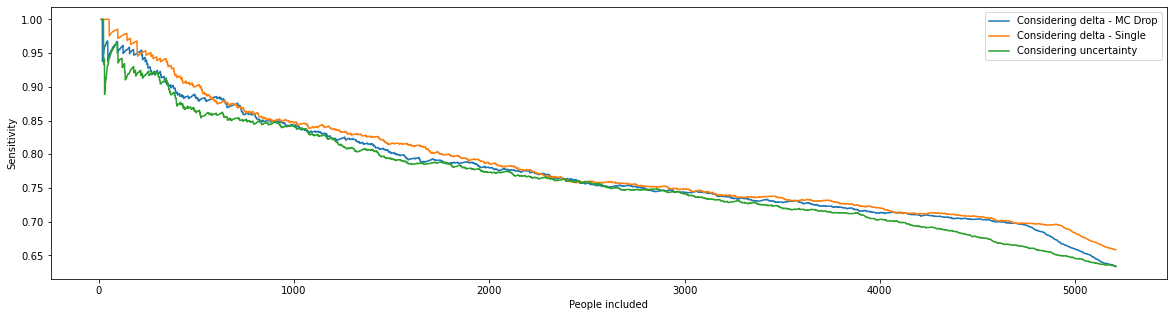

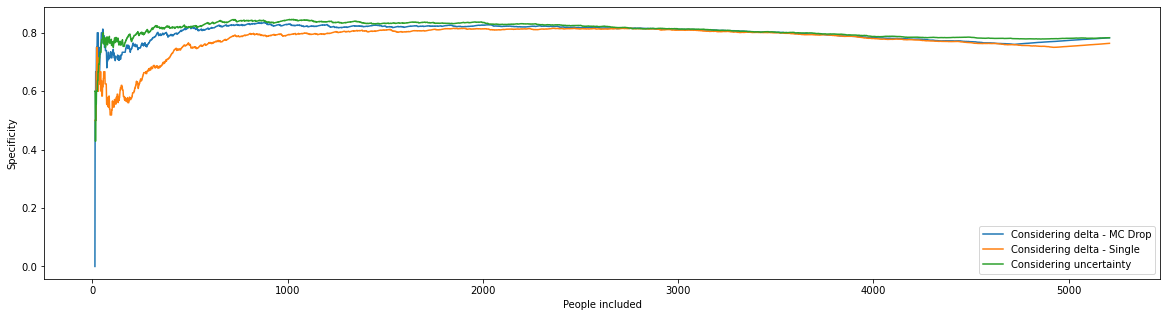

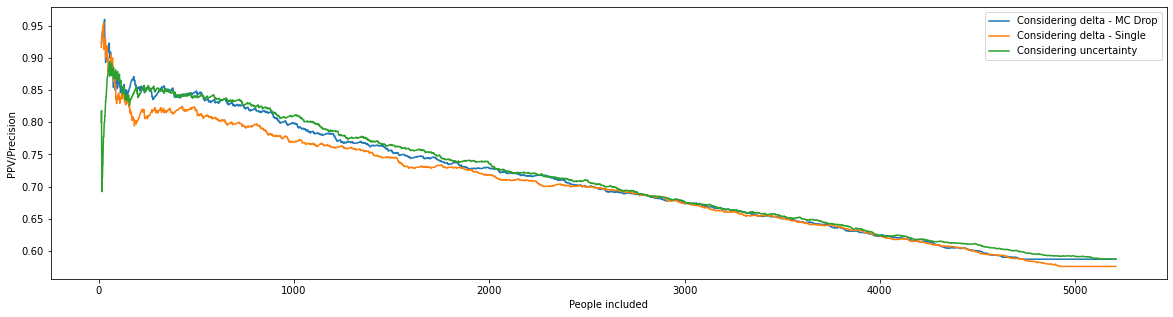

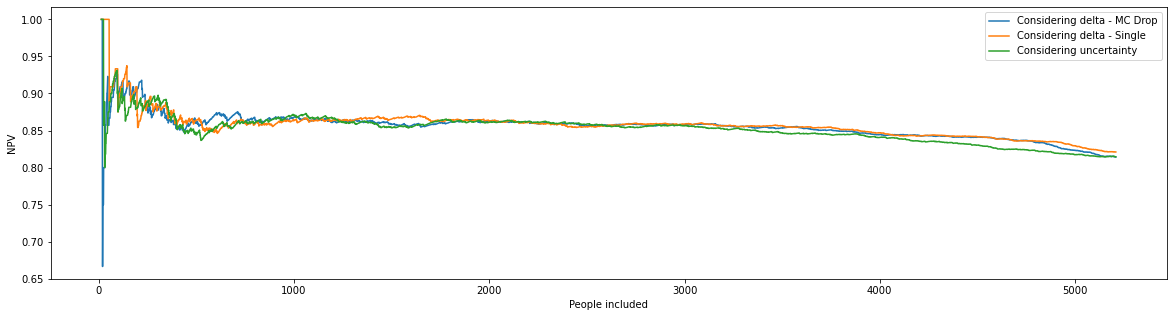

CPU times: user 1min 56s, sys: 84 ms, total: 1min 56s
Wall time: 1min 56s


In [11]:
%%time
plot_all_comparisons(joined_df, single_pass, threshold=0.582169, starting_num_people=13)